In [18]:
import pandas as pd
import numpy as np
import os
import sys
from  networkx import bipartite
sys.path.append('./../..')
sys.path.append('./..')
import glob
from tqdm import tqdm
import joblib
from joblib import Parallel, delayed
from pandarallel import pandarallel
from gensim.models import KeyedVectors
import multiprocessing as mp
pandarallel.initialize()
import re
from IPython.core.display import display, HTML
import yaml
from sklearn.preprocessing import LabelEncoder
import sys
sys.path.append('./..')
sys.path.append('./../..')
from common_utils import utils
from collections import Counter
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool
import time
import itertools
import matplotlib.pyplot as plt
import networkx as nx
id_col = 'PanjivaRecordID'
import networkx as nx
import operator
import collections
import argparse
from networkx.algorithms import community

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [114]:
config_ANOM_PERC = 1
config_MULTIPLICATIVE = 3

In [2]:
CONFIG = None
DIR_LOC = None
CONFIG = None
CONFIG_FILE = 'config.yaml'
save_dir = None
id_col = 'PanjivaRecordID'
use_cols = None
freq_bound = None
attribute_columns = None
DIR = None
CUT_OFF = None

In [3]:
# -------------------
# To find Betwenness Centrality
# -------------------

def chunks(l, n):
    """Divide a list of nodes `l` in `n` chunks"""
    l_c = iter(l)
    while 1:
        x = tuple(itertools.islice(l_c, n))
        if not x:
            return
        yield x


def betweenness_centrality_parallel(G, processes=None):
    """Parallel betweenness centrality  function"""
    p = Pool(processes=processes)
    node_divisor = len(p._pool) * 4
    node_chunks = list(chunks(G.nodes(), int(G.order() / node_divisor)))
    num_chunks = len(node_chunks)
    bt_sc = p.starmap(
        nx.betweenness_centrality_subset,
        zip(
            [G] * num_chunks,
            node_chunks,
            [list(G)] * num_chunks,
            [True] * num_chunks,
            [None] * num_chunks,
        ),
    )

    # Reduce the partial solutions
    bt_c = bt_sc[0]
    for bt in bt_sc[1:]:
        for n in bt:
            bt_c[n] += bt[n]
    return bt_c


In [4]:
def set_up_config(_DIR=None):
    global DIR
    global CONFIG
    global CONFIG_FILE
    global use_cols
    global num_neg_samples
    global DATA_SOURCE
    global DIR_LOC
    global save_dir
    global id_col
    global attribute_columns

    DATA_SOURCE = './../generated_data_v1/'
    with open(CONFIG_FILE) as f:
        CONFIG = yaml.safe_load(f)

    if _DIR is not None:
        DIR = _DIR
        CONFIG['DIR'] = _DIR
    else:
        DIR = CONFIG['DIR']

    DIR_LOC = re.sub('[0-9]', '', DIR)
    DATA_SOURCE = os.path.join(DATA_SOURCE, DIR)
    save_dir = '__2'
    save_dir = os.path.join(
        DATA_SOURCE,
        save_dir
    )
    

    if not os.path.exists(save_dir):
        os.mkdir(save_dir)

    use_cols = CONFIG[DIR]['use_cols']
    _cols = list(use_cols)
    _cols.remove(id_col)
    attribute_columns = list(sorted(_cols))
    return

In [5]:
DIR = 'us_import2'
set_up_config(DIR)
DATA_SOURCE

'./../generated_data_v1/us_import2'

In [6]:
df_train = pd.read_csv(
    os.path.join(DATA_SOURCE, 'train_data.csv'),
    low_memory=False,
    index_col=None
)

In [7]:
df_test = pd.read_csv(
    os.path.join(DATA_SOURCE, 'test_data.csv'),
    low_memory=False,
    index_col=None
)

In [8]:
def check_degree_distribution(graph_obj):
    degree_sequence = sorted([d for n, d in graph_obj.degree()], reverse=True)
    try:
        plt.title('Boxplot of degree')
        plt.boxplot(degree_sequence)
        plt.show()
    except:
        pass
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    try:
        fig, ax = plt.subplots()
        plt.bar(deg, cnt, width=0.80, color="b")
        plt.title("Degree Histogram")
        plt.ylabel("Count")
        plt.xlabel("Degree")
        plt.show()
    except:
        pass
   

In [9]:
def get_domain_dims():
    global DATA_SOURCE
    
    dom_dims_path = os.path.join(DATA_SOURCE, 'domain_dims.pkl')
    with open(dom_dims_path,'rb') as fh:
        domain_dims =  pickle.load(fh)
    return domain_dims

In [10]:
target_df = utils.convert_to_serializedID_format( target_df = df_train, DIR=DIR, data_source_loc=None,REFRESH=False)

100%|██████████| 8/8 [00:18<00:00,  2.25s/it]


In [45]:
main_df = target_df.copy()

In [11]:

def build_complete_graph(df):
    from itertools import combinations
    domain_dims = get_domain_dims()
    complete_G =nx.Graph()
    edges = [
        ['Carrier','ConsigneePanjivaID'],
        ['Carrier','HSCode'],
        ['Carrier','PortOfLading'],
        ['Carrier','PortOfUnlading'],
        ['Carrier','ShipperPanjivaID'],
        ['ConsigneePanjivaID','HSCode'],
        ['ConsigneePanjivaID','PortOfUnlading'],
        ['ConsigneePanjivaID','ShipmentDestination'],
        ['HSCode','ShipmentDestination'],
        ['HSCode','ShipmentOrigin'],
        ['HSCode','ShipperPanjivaID'],
        ['PortOfLading','ShipmentOrigin'],
        ['PortOfLading','ShipperPanjivaID'],
        ['PortOfUnlading','ShipmentDestination'],
        ['ConsigneePanjivaID','ShipperPanjivaID']
    ]
    
    for i,j in edges:
        __tmp__ = df[[i,j]]
        __tmp__ = __tmp__.drop_duplicates()
        _i = __tmp__[i].values.tolist()
        _j = __tmp__[j].values.tolist()
        n1_n2 = [ ( a,b)for a,b in zip(_i,_j)]
        complete_G.add_edges_from(n1_n2)
    return complete_G
        
complete_G = build_complete_graph(target_df)    

In [12]:
df_test = utils.convert_to_serializedID_format( target_df = df_test, DIR=DIR, data_source_loc=None,REFRESH=False)

100%|██████████| 8/8 [00:15<00:00,  1.96s/it]


In [20]:
domain_dims = get_domain_dims()
entity_type_list = {
    d : list(set(target_df[d])) for d in domain_dims.keys()
}

In [13]:
# import networkx as nx
# from node2vec import Node2Vec
# graph = complete_G.copy()
# node2vec = Node2Vec(graph, dimensions=32, walk_length=10, num_walks=200, workers=mp.cpu_count())

In [14]:
# --------------------------------------
# Used to get approximate candidates 
# --------------------------------------
def get_n2v_model(G):
    global DIR
    fname = DIR +'_node2vec'
    from nodevectors import Node2Vec
    if not os.path.exists(fname + '.zip'):
        n2v = Node2Vec()
        n2v.fit(G)
        
        n2v.save(DIR +'_node2vec')
       
    else:
        n2v = Node2Vec.load( fname + '.zip')
    return n2v


In [15]:
n2v = get_n2v_model(complete_G.copy())
# Save model to gensim.KeyedVector format
n2v.save_vectors("{}_n2v_model.bin".format(DIR))
query_model = KeyedVectors.load_word2vec_format("{}_n2v_model.bin".format(DIR))

In [148]:
# -----------------------------------------------------------
# Get ordered list of elements that are approx most dissimilar
# ------------------------------------------------------------
def query_ordered_dissimilar(ent_id, entity_type, entity_type_list , query_model, exclude_list= None):
     
    k = int(len(entity_type_list[entity_type]) * .20)
    _dict = { e1: query_model.similarity(str(ent_id),str(e1)) for e1 in entity_type_list[entity_type] }
    sorted_dict = sorted(_dict.items() ,key=operator.itemgetter(1), reverse=True)
    
    if exclude_list is not None:
        res = [ _[0] for _ in sorted_dict[-k:] if _[0] not in exclude_list]
    else:
        res = [ _[0] for _ in sorted_dict[-k:] if _[0] ]
    return res
# Example : query_ordered_dissimilar(75, 'Carrier', entity_type_list , query_model)


def query_ordered_similar(ent_id, entity_type, entity_type_list , query_model, exclude_list= None, include_list = None):
     
    k = int(len(entity_type_list[entity_type]) * .25)
    _dict = { e1: query_model.similarity(str(ent_id),str(e1)) for e1 in entity_type_list[entity_type] }
    sorted_dict = sorted(_dict.items() ,key=operator.itemgetter(1), reverse=True)
    
    if exclude_list is not None:
        res = [ _[0] for _ in sorted_dict[:k] if _[0] not in exclude_list]
    else:
        res = [ _[0] for _ in sorted_dict[:k]  ]
   
    if include_list is not None:
        res = [ _ for _ in res if _ in include_list]
    else:
        res = [ _ for _ in res ]
        
    return res
# Example : query_ordered_similar(75, 'Carrier', entity_type_list , query_model)

In [57]:
def get_nonCoOcc(ent_id, e_type, target_e_type):
    global main_df
    global entity_type_list
    
    tmp = set(main_df[[e_type, target_e_type]].loc[main_df[e_type]==ent_id][target_e_type].values.tolist())
    return list(set(entity_type_list[target_e_type]).difference(tmp))
# Example : get_nonCoOcc(45, 'Carrier', 'HSCode'))

In [44]:
# 
# =======================================
company_cols = ['ConsigneePanjivaID', 'ShipperPanjivaID']


df = target_df.copy()
print('>> ', len(df))
attributes = [ _ for _ in list(df.columns) if _ not in id_col]
df = df.drop_duplicates(subset = attributes)
df_subset = df[company_cols].groupby(
    company_cols).size().reset_index(
    name='count'
).sort_values(by='count', ascending=False)



# --------------------
# Create a bipartite graph
# --------------------
B = nx.Graph()
B.add_nodes_from(set(df_subset['ConsigneePanjivaID'].values), bipartite=0)
B.add_nodes_from(set(df_subset['ShipperPanjivaID'].values), bipartite=1)
edges = []

for i, j, k in zip(df_subset['ConsigneePanjivaID'].values,
                   df_subset['ShipperPanjivaID'].values,
                   df_subset['count'].values):
    edges.append((i, j, {'weight': k}))

B.add_edges_from(edges)
print(' IS the bipartite graph of Comapnies connected ? ', nx.is_connected(B))

>>  68257
 IS the bipartite graph of Comapnies connected ?  False


In [58]:
 
def get_largest_component_subgraph(graph_obj):
    component_id = 0
    components = {}
    component_size_dict = {}

    for c in nx.connected_components(graph_obj):
        components[component_id] = c
        component_size_dict[component_id] = len(c) 
        component_id += 1
        
    component_size_dict = sorted(component_size_dict.items(), key=operator.itemgetter(1), reverse=True)
    # Get the largest connected component
    max_component = components[component_size_dict[0][0]]
    subgraph = graph_obj.subgraph(max_component)
    return subgraph , component_size_dict

In [59]:
def get_graph_components(graph_obj):
    component_id = 0
    components = {}
    component_size_dict = {}

    for c in nx.connected_components(graph_obj):
        components[component_id] = c
        component_size_dict[component_id] = len(c) 
        component_id += 1
        
    component_size_dict = sorted(component_size_dict.items(), key=operator.itemgetter(1), reverse=True)
    
    components_dict = []
    for i, _size in component_size_dict:
        components_dict.append((i, _size,   components[i]))
      
    return components_dict

In [60]:
B0, _ = get_largest_component_subgraph(B)

In [61]:
B0.number_of_nodes()

10130

In [62]:
nx.info(complete_G)

'Name: \nType: Graph\nNumber of nodes: 14353\nNumber of edges: 164768\nAverage degree:  22.9594'

In [64]:
bt_sorted = betweenness_centrality_parallel(B0)
bt_sorted = sorted(bt_sorted.items(), key=operator.itemgetter(1), reverse=True)

In [65]:
centrality_d = nx.degree_centrality(B0)
centrality_d = sorted(centrality_d.items(), key=operator.itemgetter(1), reverse=True)

In [81]:
top_K_companies = set([_[0] for _ in  bt_sorted[:50] + centrality_d[:50]])
top_K_companies = list(set(top_K_companies))
tmp1 = df.loc[(df['ConsigneePanjivaID'].isin(top_K_companies)) | (df['ShipperPanjivaID'].isin(top_K_companies))].copy()
#The set of HS codes that are mostly transacted

popular_hscodes = set(tmp1['HSCode'])
hscode_degree_dict = {node_hsc : complete_G.degree(node_hsc) for node_hsc in popular_hscodes}
K = int(len(hscode_degree_dict)*0.5)
top_K_hscodes = [_[0] for _ in sorted(hscode_degree_dict.items() , key = operator.itemgetter(1), reverse=True)][:K]

In [84]:
# =====================================
# To get community/clusters of nodes ,
# We remove some highly visible nodes
# =====================================
rmv = []
K = 1000
for sorted_dict in [ bt_sorted, centrality_d]:
    rmv.extend( [ _[0] for _ in sorted_dict[:K] ])
rmv = list(set(rmv))

In [86]:
B1 = nx.Graph(B0)
print(B1.number_of_edges(), B1.number_of_nodes())

B1.remove_nodes_from(rmv)
print(B1.number_of_edges(), B1.number_of_nodes())

22382 10130
5942 8738


In [90]:
max_comp, _components = get_largest_component_subgraph(B1)
g_components = get_graph_components(B1)

In [89]:
set_PoL =  set(df['PortOfLading'])

PoL_distances = {}
for h in set_PoL:
    _dict = {_h:len(nx.shortest_path(complete_G, h,_h))-2 for _h in set_PoL if _h != h }
    PoL_distances[h] = sorted(_dict.items(), key = operator.itemgetter(1), reverse=True)

In [92]:
domain_dims = get_domain_dims()
domain_dims

{'Carrier': 589,
 'ConsigneePanjivaID': 5817,
 'HSCode': 125,
 'PortOfLading': 243,
 'PortOfUnlading': 67,
 'ShipmentDestination': 126,
 'ShipmentOrigin': 115,
 'ShipperPanjivaID': 7271}

In [112]:
required_length = int(len(df_test)*config_ANOM_PERC/100)
print( required_length )

348


In [117]:
348/(111*3)

1.045045045045045

In [126]:

positive_candidate = None
subgraph_induced_df_list = []
# Leave out the largest community

for i in range(1,10):
    g = B1.subgraph(g_components[i][-1])
    # what are the entity ids ?
    
    # Omit nodes which have degree 1
    _nodes_ = [ _ for _ in g.nodes() if g.degree(_)>1]
    tmp_df = df.loc[(df['ConsigneePanjivaID'].isin(_nodes_)) & (df['ShipperPanjivaID'].isin(_nodes_))].copy()

    
    subgraph_induced_df_list.append(tmp_df)
    if (len(tmp_df)* config_MULTIPLICATIVE/ required_length) < 1.1 and (len(tmp_df)*config_MULTIPLICATIVE / required_length) > 0.9 :
        print('Valid candidate found')
        tmp_df = tmp_df.sample(n = int(required_length/config_MULTIPLICATIVE), replace=True) 
        print( '>>', tmp_df.shape[0], len(set(tmp_df['ConsigneePanjivaID'])), len(set(tmp_df['ShipperPanjivaID'])))
        positive_candidate = tmp_df.copy().reset_index(drop=True)
        break

Valid candidate found
>> 116 30 31


In [93]:
g = B.subgraph(g_components[2][-1])
print(nx.info(g))
# what are the entity ids ?
list_e = list(g.nodes())
tmp_df = df.loc[(df['ConsigneePanjivaID'].isin(list_e)) & (df['ShipperPanjivaID'].isin(list_e))].copy()

Name: 
Type: Graph
Number of nodes: 111
Number of edges: 125
Average degree:   2.2523


In [124]:
set(positive_candidate['HSCode'])
query_ordered_dissimilar(ent_id, entity_type, entity_type_list , query_model, exclude_list= None)

{6473, 6488, 6491, 6494, 6496, 6499, 6500, 6512, 6516}

In [233]:
def generate_aux(cand_df, idx, num_samples, perturb_extra= True):
    global df
    global query_model
    global entity_type_list
    global id_col
    global domain_dims
    print(cand_df.loc[idx])
    # Choose the anchor point
    a = np.random.uniform()
    
    if a < 0.5: 
        company_anchor = 'ConsigneePanjivaID'
        domain_set_1 = ('HSCode',  'ShipmentOrigin')
        domain_set_2 = ('Carrier', 'PortOfLoading')
    else:
        company_anchor = 'ShipperPanjivaID'
        domain_set_1 = ( 'HSCode', 'ShipmentDestination')
        domain_set_2 = ('Carrier', 'PortOfUnlading')
    
    d_set = domain_set_1
    print(d_set)
    if perturb_extra:
        perturb_columns = [ _ for _ in domain_dims.keys() if _ not in ['ConsigneePanjivaID','ShipperPanjivaID'] + list(d_set) ]
        
    
    comp_ent = cand_df.loc[idx, company_anchor]
    a1 = get_nonCoOcc(ent_id=comp_ent, e_type=company_anchor, target_e_type=d_set[0])
    a2 = query_ordered_dissimilar(
        ent_id = comp_ent, 
        entity_type = d_set[0], 
        entity_type_list = entity_type_list,
        query_model=query_model,
        exclude_list= None)
    a3 = list(set(a1).intersection(set(a2)))
    
    b1 = get_nonCoOcc(ent_id=comp_ent, e_type=company_anchor, target_e_type=d_set[1])
    b2 =  query_ordered_dissimilar(
            ent_id = comp_ent, 
            entity_type = d_set[1], 
            entity_type_list = entity_type_list,
            query_model=query_model,
            exclude_list= None
            )
    b3 = set(b1).intersection(set(b2))
    
    
    e1_0 = np.random.choice(a3, size=1, replace=False)[0]
    e1_ = query_ordered_similar(
        ent_id = e1_0, 
        entity_type = d_set[0], 
        entity_type_list = entity_type_list,
        query_model=query_model,
        exclude_list= [e1_0],
        include_list = list(a3)
    )
    
    e1 = [e1_0] + e1_[:num_samples-1]
    
    e2_0 = np.random.choice(a3, size=1, replace=False)[0]

    e2_ = query_ordered_similar(
        ent_id = e2_0, 
        entity_type = d_set[1], 
        entity_type_list = entity_type_list,
        query_model=query_model,
        exclude_list= [e2_0],
        include_list = list(b3)
    )
        
    e2 = [e2_0] + e2_[:num_samples-1]
    print(e1,e2)
    res = []
    for i in range(num_samples):
        row_copy = cand_df.loc[idx].copy()
        row_copy[id_col] = int(str(row_copy[id_col]) + '00{}'.format(i+1))
        row_copy[d_set[0]]= e1[i]
        row_copy[d_set[1]]= e2[i]
        _p = np.random.choice(perturb_columns,size=1)[0]
        print('>',_p)
        row_copy[_p] = np.random.choice(entity_type_list[_p],size=1)[0]
        res.append(row_copy)
    res = pd.concat(res,axis=1).transpose().reset_index(drop=True)
     
    return res


In [235]:
r = generate_aux(cand_df = positive_candidate, idx=100, num_samples=3)
r

PanjivaRecordID        112042092
Carrier                      244
ConsigneePanjivaID           900
HSCode                      6494
PortOfLading                6582
PortOfUnlading              6789
ShipmentDestination         6877
ShipmentOrigin              6987
ShipperPanjivaID            9738
Name: 100, dtype: int64
('HSCode', 'ShipmentDestination')
[6434, 6475, 6441] [6468, 6902, 6945]
> PortOfUnlading
> Carrier
> PortOfLading


,PanjivaRecordID,Carrier,ConsigneePanjivaID,HSCode,PortOfLading,PortOfUnlading,ShipmentDestination,ShipmentOrigin,ShipperPanjivaID
0,112042092001,244,900,6434,6582,6808,6468,6987,9738
1,112042092002,136,900,6475,6582,6789,6902,6987,9738
2,112042092003,244,900,6441,6551,6789,6945,6987,9738


In [208]:
r = get_nonCoOcc(ent_id=4684, e_type='ConsigneePanjivaID', target_e_type='Carrier')
len(r)

587

In [156]:
required_length*2/6

116.0

In [98]:
query_ordered_dissimilar(ent_id = 115, entity_type= 'Carrier', entity_type_list = entity_type_list , query_model = query_model)[:25]

[222,
 144,
 71,
 507,
 362,
 467,
 442,
 448,
 559,
 431,
 518,
 203,
 19,
 340,
 61,
 259,
 506,
 43,
 367,
 522,
 264,
 1,
 311,
 253,
 470]

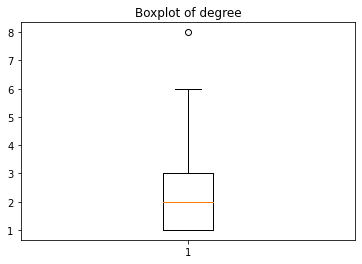

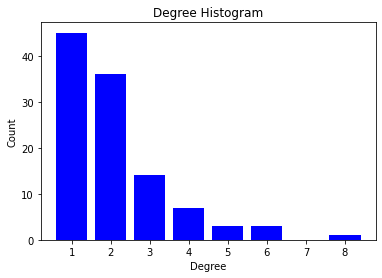

In [45]:
_tmp_graph =  B.subgraph(g_components[3][-1])
check_degree_distribution(_tmp_graph)

In [12]:
 
def get_largest_component_subgraph(graph_obj):
    component_id = 0
    components = {}
    component_size_dict = {}

    for c in nx.connected_components(graph_obj):
        components[component_id] = c
        component_size_dict[component_id] = len(c)
        component_id += 1
    component_size_dict = sorted(component_size_dict.items(), key=operator.itemgetter(1), reverse=True)
    # Get the largest connected component
    max_component = components[component_size_dict[0][0]]
    subgraph = graph_obj.subgraph(max_component)
    return subgraph